# Visión por Computador - Práctica 1
## Filtrado y muestreo

### A) Implementar una función de convolución que debe ser capaz de calcular la convolución 2D de una imagen con una máscara. Ahora supondremos que la máscara es extraída del muestreo con una Gaussiana 2D simétrica. Para ello implementaremos las siguientes funciones auxiliares:

#### 1. Cálculo del vector máscara: Sea $f(x) = e^{\left(-0.5\frac{x^2}{\sigma^2}\right)}$ una funcion donde $\sigma$ representa un parámetro en unidades píxel. Implementar una función que tomando $\sigma$ como parámetro de entrada devuelva una máscara de convolución representativa de dicha función. Justificar los pasos dados.

#### 2. Implementar una función que calcule la convolución de un vector señal 1D con un vector-máscara 1D de longitud inferior al de la señal usando dos posibles tipos de condiciones de entorno (uniforme a ceros y reflejada). La salida será un vector de igual longitud que el vector señal de entrada. Pasos:

   ##### a) Implementar una función que calcule la convolución 1D entre dos vectores, dando de salida solo los valores donde ha sido posible el cálculo.
    
   ##### b) Definir un vector auxilar de longitud mayor definida a partir de las dimensiones de los dos vectores de entrada, p.e. la señal tiene longitud $N$ y el otro $2k + 1$ entonces el vector auxiliar será $N+2k$. Copiar en su centro el vector señal y rellenar los extremos usando el criterio de borde elegido. 
    
   ##### c) Ejecutar la función del paso a sobre el vector creado y la máscara. En el caso de que el vector de entrada sea de color, habrán de extraerse cada uno de los tres vectores correspondientes a cada uno de ellos y volver a montar el vector de salida. Usar las funciones *split()* y *merge()* de openCV.
    
#### 3. Implementar una función que tomando como entrada una imagen y el valor de $\sigma$ calcule la convolución de dicha imagen con uma máscara Gaussiana 2D. Usar las funciones implementadas en el punto anterior. Recordar que la Gaussiana es descomponible en convoluciones 1D por filas y columnas.

- **Apartado 1**: Para resolver el apartado 1, se ha creado la función ***get_mask_vector*** que recibe como parámetro de entrada el valor de $\sigma$. Una vez dentro de la función, muestrearemos $f(x)$ entre los valores $-3\sigma$ y $3\sigma$.

    Para ello, en el intervalo $\left[\lfloor-3\sigma\rfloor, \lceil3\sigma\rceil\right]$, muestrearemos los $n$ valores enteros que haya en este intervalo, obteniendo un vector de enteros. Sobre este vector de enteros, aplicaremos la función $f(x)$ a este vector obteniendo así la máscara, pero sin normalizar.

    Una vez obtenida, los valores que se encuentren por debajo de $|3\sigma|$, los llevaremos a 0, ya que consideraremos que son poco relevantes y que influyen muy poco en el resultado. Tras esto, normalizaremos a 1 la máscara y se devolverá.

In [53]:
import cv2 # OpenCV2
import numpy as np
import math
from matplotlib import pyplot as plt # necesario para mostrar imágenes en jupyter

# Realiza la función exponencial del enunciado
fx = lambda x, sigma: math.exp(-0.5 * (x ** 2 / sigma ** 2))

# Devuelve el vector gaussiano de la máscara
def get_mask_vector(sigma):
    # Obtenemos el valor "límite" que puede tener un
    # píxel para que sea significativo
    limit_3sigma = fx(3 * sigma, sigma)
    # Obtenemos un array de valores discretos
    # para realizar la gaussiana
    aux = np.arange(math.floor(-3 * sigma), math.ceil(3 * sigma )+ 1)
    # Rellenamos la máscara aplicando la exponencial
    mask = np.array([fx(i, sigma) for i in aux])
    # Despreciamos los valores menores a 3 sigma
    mask[mask < limit_3sigma] = 0
    # Normalizamos la máscara a 1
    mask = np.divide(mask, np.sum(mask))
    # Devolvemos la máscara
    return mask

- **Apartado 2 - a**: para resolver el apartado dos, primero tenemos que fijarnos en cómo se realiza una convolución. $$G[i,j] = \sum_{u=-k}^k\sum_{v=-k}^kH[u,v]F[i-u,j-v]$$

    Al ser una función Gaussiana, tendremos una máscara con valores simétricos, por lo que podemos simplificar la expresión haciendo que la convolución se resuma en multiplicar la máscara por el vector 1D, y obtener la suma del vector resultante, siendo esta el valor de $G[i,j]$.

In [54]:
def convolution(mask, img_array):
    return np.sum(img_array * mask)

En esta función, se recibe como parámetro la máscara gaussiana, y un array 1D perteneciente a la imagen, y devuelve el valor que se le asignará al píxel $G_{ij}$.

- **Apartado 2 - b**: para definir este vector auxiliar, se han generado varias funciones para esta tarea. Una de ellas generará la imagen auxiliar de tamaño $N+2k$ y copiará en su centro la imagen original, y el resto se encargarán de rellenar los bordes de la imagen auxiliar de una forma u otra. En OpenCV existen distintas formas de rellenar los bordes:
    * **Replicado**: replica el último píxel que hay en el borde de la imagen $n$ veces.
    * **Reflejado**: coge los $n$ últimos píxeles del borde y los añade en orden inverso.
    * **Reflejado 101**: similar al anterior, pero añade los píxeles en el lado contrario del que se toman.
    * **Wrap o envoltura**: toma los $n$ píxeles cercanos al borde y los añade en el mismo orden al lado inverso de la imagen.
    * **Constante**: añade a los bordes píxeles con un valor constante $k$.
 
 Para empezer, la función ***extend_image_n_pixels*** recibe como parámetros la imagen original, el número de píxeles que se desea extender, el tipo de borde que se desea (que se codifica con un entero), y una constante $k$ para rellenar los píxeles con esa constante en caso de que se elija esta opción, que por defecto es 0. Esta función, distingue entre imágenes en color e imágenes en escala de grises.
     * **Imágenes en escala de grises**: llama a la función ***extend*** y genera la imagen extendida según los parámetros recibidos.
     * **Imágenes en color**: utilizando la función ***split***, obtenemos el canal azul, verde y rojo de la imagen original, y con cada uno de ellos se llama a la función ***extend***. Una vez extendidos los tres canales, se unen usando la función ***merge*** de OpenCV.
     
 La función ***extend*** recibe la imagen (o canal) que queremos ampliar, el número de píxeles, el borde y la constante que se usa en caso de se use la extensión con una constante. Genera una matriz auxiliar con de ceros e inserta la imagen en el centro usando la función ***insert_img_into_other***. Tras esto, extiende la imagen según el criterio elegido.

In [67]:
def insert_img_into_other(img_src, pixel_left_top_row, 
                          pixel_left_top_col, 
                          img_dest,substitute=False):
    alt, anch = img_src.shape[:2]
    if not substitute:
        img_dest[pixel_left_top_row:alt+pixel_left_top_row,
                 pixel_left_top_col:anch+pixel_left_top_col] += img_src
    else:
        img_dest[pixel_left_top_row:alt + pixel_left_top_row,
                 pixel_left_top_col:anch + pixel_left_top_col] = img_src
        
# Border replicate => coge el último píxel y lo replica
# n_pixels veces
def border_replicate(img, n_pixels, alt, anch):
    img[0:n_pixels, ] = img[n_pixels,]
    img[n_pixels + alt:(alt + 2 * n_pixels), ] = img[-n_pixels-1,]
    for i in range(n_pixels):
        img[:, i] = img[:, n_pixels]
    for i in range(n_pixels + anch, img.shape[1]):
        img[:, i] = img[:, -n_pixels-1]

# Border reflect => refleja n_pixels del borde y los añade
# al borde por ambos lados
def border_reflect(img, n_pixels, alt, anch):
    # Borde superior
    img[0:n_pixels, ] = np.matrix(img[n_pixels:n_pixels * 2, ])[::-1]
    # Borde inferior
    img[n_pixels + alt:(alt + 2 * n_pixels), ] = \
        np.matrix(img[(-2 * n_pixels):(-n_pixels), ])[::-1]
    # Para invertir los bordes de los laterales, no podemos usar el "atajo" de [::-1] para
    # invertir la matriz. Para ello, usaremos la función fliplr de numpy que nos devuelve
    # la matriz con las columnas en orden inverso
    # Borde izquierdo
    img[:, 0:n_pixels] = np.fliplr(img[:, n_pixels:2 * n_pixels])
    # Borde derecho
    img[:, n_pixels + anch:img.shape[1]] = \
        np.fliplr(img[:, (-2 * n_pixels):(-n_pixels)])

# Border reflect 101 => similar al anterior, pero, refleja
# el borde en el borde contrario de la imagen
def border_reflect_101(img, n_pixels, alt, anch):
    # Borde superior
    img[0:n_pixels, ] = np.matrix(img[(-2 * n_pixels):(-n_pixels), ])[::-1]
    # Borde inferior
    img[n_pixels + alt:(alt + 2 * n_pixels), ] = \
        np.matrix(img[n_pixels:n_pixels * 2, ])[::-1]
    # Borde izquierdo
    img[:, 0:n_pixels] = np.fliplr(img[:, (-2 * n_pixels):(-n_pixels)])
    # Borde derecho
    img[:, n_pixels + anch:img.shape[1]] = \
        np.fliplr(img[:, n_pixels:2 * n_pixels])

# Border wrap => toma los últimos n_pixels de un borde de la
# imagen, y los añade tal cual al otro borde de la imagen
def border_wrap(img, n_pixels, alt, anch):
    # Borde superior
    img[0:n_pixels, ] = np.matrix(img[(-2 * n_pixels):(-n_pixels), ])
    # Borde inferior
    img[n_pixels + alt:(alt + 2 * n_pixels), ] = \
        np.matrix(img[n_pixels:n_pixels * 2, ])
    # Borde izquierdo
    img[:, 0:n_pixels] = img[:, (-2 * n_pixels):(-n_pixels)]
    # Borde derecho
    img[:, n_pixels + anch:img.shape[1]] = \
        img[:, n_pixels:2 * n_pixels]


# Border constant => a partir de una constante k, añade a los bordes
    # píxeles con valor k
def border_constant(img, n_pixels, alt, anch, k):
    # Borde superior
    img[0:n_pixels, ] = np.ones((n_pixels, img.shape[1]), dtype=np.uint8) * k
    # Borde inferior
    img[n_pixels + alt:(alt + 2 * n_pixels), ] = \
        np.ones((n_pixels, img.shape[1]), dtype=np.uint8) * k
    # Borde izquierdo
    img[:, 0:n_pixels] = np.ones((img.shape[0], n_pixels), dtype=np.uint8) * k
    # Borde derecho
    img[:, n_pixels + anch:img.shape[1]] = \
        np.ones((img.shape[0], n_pixels), dtype=np.uint8) * k


def extend(img_src, n_pixels, border_type, k):
    # Tomamos la altura y el ancho de la imagen original
    alt, anch = img_src.shape[:2]
    # Generamos una nueva matriz expandida a partir del
    # alto y ancho de la anterior
    new_extended_img = np.zeros((alt + 2 * n_pixels, 
                                 anch + 2 * n_pixels), dtype=np.uint8)

    insert_img_into_other(img_src=img_src, pixel_left_top_row=n_pixels,
                          pixel_left_top_col=n_pixels, img_dest=new_extended_img)

    if border_type == 0:    # Border Replicate
        border_replicate(new_extended_img, n_pixels, alt, anch)
    elif border_type == 1:  # Border Reflect
        border_reflect(new_extended_img, n_pixels, alt, anch)
    elif border_type == 2:  # Border Reflect 101
        border_reflect_101(new_extended_img, n_pixels, alt, anch)
    elif border_type == 3:  # Border wrap
        border_wrap(new_extended_img, n_pixels, alt, anch)
    elif border_type == 4:  # Border Constant
        border_constant(new_extended_img, n_pixels, alt, anch, k)

    return new_extended_img


def extend_image_n_pixels(img_src, n_pixels, border_type, k=0):

    if len(img_src.shape) != 3: # Imagen en escala de grises
        return extend(img_src, n_pixels, border_type, k)
    
    else:   # Imagen en color
        b_channel, g_channel, r_channel = cv2.split(img_src)

        b_channel_ext = extend(b_channel, n_pixels, border_type, k)
        g_channel_ext = extend(g_channel, n_pixels, border_type, k)
        r_channel_ext = extend(r_channel, n_pixels, border_type, k)

        return cv2.merge((b_channel_ext, g_channel_ext, r_channel_ext))

   
# Esta función nos sirve para mostrar una lista de
# imágenes de forma continua en un mismo canvas
def generate_continous_canvas(list_imgs):
    length, height = 0, 0

    max_of = max
    # Obtenemos la anchura máxima del canvas
    # y la altura máxima que debe tener para que
    # pueda a
    color_imgs = False
    for i in list_imgs:
        alt, anch = i.shape[:2]
        length+=anch
        height = max_of(height, alt)

        if len(i.shape) == 3:
            color_imgs = True

    if not color_imgs:
        canvas = np.ones((height, length), dtype=np.uint8)*255
    else:
        canvas = np.ones((height, length, 3), dtype=np.uint8) * 255

    length = 0
    for i in list_imgs:
        insert_img_into_other(i, 0, length, canvas, substitute=True)
        length+=i.shape[1]


    return canvas


def show_img_on_jupyter(im):
    img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

A continuación vemos un ejemplo de cada uno de los bordes implementados cómo cambia el borde de la imagen:

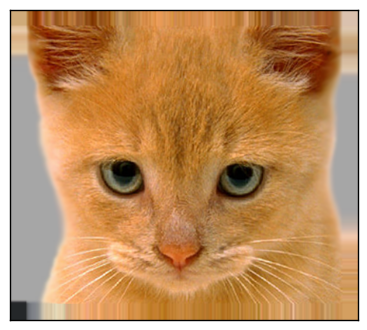

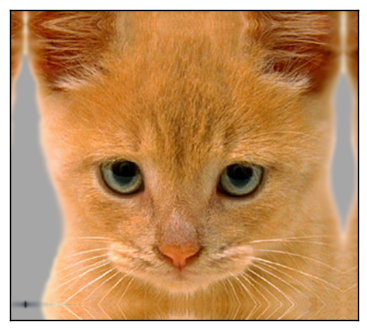

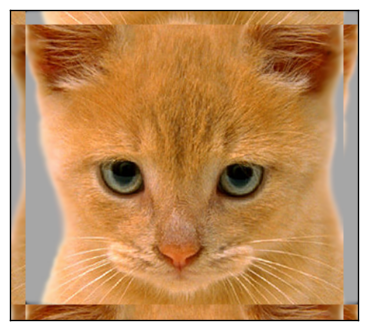

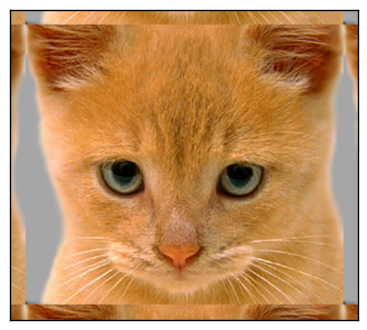

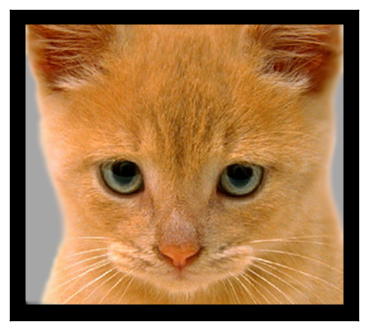

In [56]:
cat = cv2.imread('data/cat.bmp', flags=cv2.IMREAD_COLOR)
show_img_on_jupyter(extend_image_n_pixels(cat, 20, 0))
show_img_on_jupyter(extend_image_n_pixels(cat, 20, 1))
show_img_on_jupyter(extend_image_n_pixels(cat, 20, 2))
show_img_on_jupyter(extend_image_n_pixels(cat, 20, 3))
show_img_on_jupyter(extend_image_n_pixels(cat, 20, 4))

- **Apartado 2 - c**: la función definida para pasar la máscara a la imagen es ***convolution_grey_scale_img*** y ***convolution_color_img***, que reciben como parámetros la máscara, las imágenes extendidas, el número de píxeles que se ha extendido la imágen que entra como parámetro. Tras esto, se genera una copia de la imagen, se realiza la convolución en horizontal, se genera otra copia auxiliar, y se realiza la convolución en vertical. Si la imagen es en color o en escala de grises, tenemos las siguientes diferencias:
    * **Imágenes en color**: separa la imagen con la función ***split*** y se aplica la máscara a cada uno de los canales de color por separado, para luego volver a juntar los canales en una sola imagen con la función ***merge*** de OpenCV.
    * **Imágenes en escala de grises**: directamente aplica el filtro a la imagen, ya que al ser un único canal con la intensidad de cada píxel, puede realizarse sin tener que separar la imagen.

Al final, devolvemos la imagen resultante sin los bordes que se añadieron para poder hacer la convolución.

In [57]:
def convolution_grey_scale_img(mask, img, n_pixels):
    # Obtenemos el alto y ancho de la imagen
    alt_ext, anch_ext = img.shape[:2]

    cv = convolution
    copy = np.copy

    # Obtenemos una matriz auxiliar
    aux = copy(img)

    for i in range(n_pixels, alt_ext - n_pixels):
        for j in range(n_pixels, anch_ext - n_pixels):
            aux[i, j] = cv(mask, img[i, j - n_pixels:1 + j + n_pixels])

    aux_2 = copy(aux)

    for j in range(n_pixels, anch_ext - n_pixels):
        for i in range(n_pixels, alt_ext - n_pixels):
            aux_2[i, j] = cv(mask, aux[i - n_pixels:1 + i + n_pixels, j])

    return aux_2[n_pixels:-n_pixels, n_pixels:-n_pixels]


def convolution_color_img(mask, img, n_pixels):
    # Obtenemos el alto y ancho de la imagen
    alt_ext, anch_ext = img.shape[:2]

    # Separamos los colores de la imagen en tres canales
    b_channel, g_channel, r_channel = cv2.split(img)

    cv = convolution
    copy_img = np.copy
    zeros = np.zeros

    # Obtenemos una matriz auxiliar por cada uno de
    # los canales de color de la imagen
    aux_r = zeros((alt_ext, anch_ext), dtype=np.uint8)
    aux_g = zeros((alt_ext, anch_ext), dtype=np.uint8)
    aux_b = zeros((alt_ext, anch_ext), dtype=np.uint8)
    # Empezamos
    for i in range(n_pixels, alt_ext - n_pixels):
        for j in range(n_pixels, anch_ext - n_pixels):
            aux_b[i, j] = cv(mask, b_channel[i, j - n_pixels:1 + j + n_pixels])
            aux_g[i, j] = cv(mask, g_channel[i, j - n_pixels:1 + j + n_pixels])
            aux_r[i, j] = cv(mask, r_channel[i, j - n_pixels:1 + j + n_pixels])

    # Volvemos a tomar los valores de los bordes
    r_channel, g_channel, b_channel = copy_img(aux_r), copy_img(aux_g), copy_img(aux_b)
    # Y obtenemos nuevas matrices auxilares para terminar la convolucion
    aux2_r, aux2_g, aux2_b = copy_img(r_channel), copy_img(g_channel), copy_img(g_channel)

    for j in range(n_pixels, anch_ext - n_pixels):
        for i in range(n_pixels, alt_ext - n_pixels):
            aux2_b[i, j] = cv(mask, b_channel[i - n_pixels:1 + i + n_pixels, j])
            aux2_g[i, j] = cv(mask, g_channel[i - n_pixels:1 + i + n_pixels, j])
            aux2_r[i, j] = cv(mask, r_channel[i - n_pixels:1 + i + n_pixels, j])

    # Recomponemos la imagen
    result = cv2.merge((aux2_b, aux2_g, aux2_r))

    # Y la devolvemos
    return result[n_pixels:-n_pixels, n_pixels:-n_pixels]

- **Apartado 3**: con las funciones anteriormente definidas, podemos crear la función ***my_im_gauss_convolution*** encargada de realizar la convolución con la máscara 2D Gaussiana. Esta función recibe como parámetros la imagen original, la máscara gaussiana y el tipo de borde. Una vez dentro, calcula el número de píxeles que debe añadir a la imagen en cada borde, la extiende según el borde elegido y a continuación realiza la convolución. Si la imagen es en color, la matriz asociada a la imagen tendrá tres dimensiones, por lo que es fácil saber si una imagen es en color o en escala de grises, viendo si su ***shape*** o forma tiene una longitud igual a 3, lo que significa que es en color y se llamará a la función ***convolution_color_img*** para realizar la convolución. En caso contrario, se llamará a ***convolution_grey_scale_img***.

In [58]:
def my_im_gauss_convolution(im, mask_convolution,
                            border_type=0):
    # Extendemos los bordes de la imagen para hacer posible el uso de la
    # mascara sobre esta
    n_pixels = math.floor(mask_convolution.size / 2)

    extended_image = extend_image_n_pixels(im, n_pixels, border_type)
    # Si la imagen está en blanco y negro,
    if len(im.shape) != 3:
        return convolution_grey_scale_img(mask_convolution,
                                          extended_image, n_pixels)
    else:
        return convolution_color_img(mask_convolution,
                                     extended_image, n_pixels)

A continuación, podemos ver un ejemplo de uso de la función ***my_im_gauss_convolution***, viendo por pantalla la imagen original y la suavizada, gracias a la función ***generate_continous_canvas***.

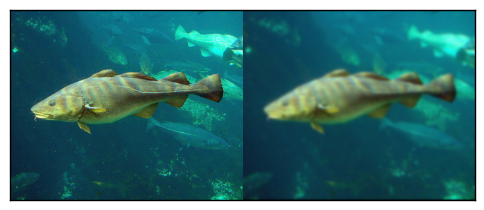

In [59]:
fish = cv2.imread('data/fish.bmp', flags=cv2.IMREAD_COLOR)
mask = get_mask_vector(2)
smoothed_fish = my_im_gauss_convolution(fish, mask)
canvas=generate_continous_canvas([fish, smoothed_fish])
show_img_on_jupyter(canvas)

### B) Imágenes híbridas

#### Mezclando adecuadamente una parte de las frecuencias altas de una imagen con una parte de las frecuencias bajas de otra imagen, obtenemos una imagen híbrida que admite distintas interpretaciones a distintas distancias. Para seleccionar la parte de frecuencias altas y bajas que nos quedamos de cada una de las imágenes usaremos el parámetro $\sigma$ del núcleo/máscara de alisamiento gaussiano que usaremos. A mayor valor de sigma, mayor eliminación de altas frecuencias de la imagen convoluconada. Para una buena implementación, elegir dicho valor de forma separada para cada una de las dos imágenes. Recordar que las máscaras 1D siempre deben tener de longitud un número impar.  Usar la función que hemos implementado en el apartado A para elegir los sigmas más adecuados a para la selección de frecuencias en parejas de imágenes.

##### 1. Implementar una función que genera las imágenes de baja y alta frecuencia.
##### 2. Escribir una función para mostrar las tres imágenes (alta, baja e híbrida) en una misma ventana. 

- **Apartado 1**: para resolver este apartado, se ha creado la función ***make_hybrid_image***. Esta función recibe como parámetros la imagen de la que se obtendrán las bajas frecuencias, la imagen de la que se obtendrán las altas frecuencias y los $\sigmas$ correspondientes. Dentro de esta función, obtenemos las bajas frecuencias de la primera imagen, pasando una máscara gaussiana y suavizándola. 

    En la segunda imagen, repetimos el proceso para obtener las bajas frecuencias de la segunda imagen. Una vez obetenida la imagen con las frecuencias bajas, si a la imagen original le restamos la imagen con las frecuencias bajas, lo que obtenemos son las frecuencias altas de la imagen. De esta forma se obtienen las frecuencias altas de la segunda imagen. Para obtener la imágen híbrida, sumamos las frecuencias altas y bajas de las imágenes obteniendo así la imagen híbrida.

    Para mostrar las tres imágenes en el mismo canvas, llamaremos a la función ***generate_continous_canvas***, que recibe como parámetros la lista de imágenes obtenidas y genera una imagen en la que se encuentran las tres imágenes seguidas una a continuación de otra en el mismo canvas. Para mostrarla por pantalla, se usará la función ***imshow*** de OpenCV.

In [60]:
def make_hybrid_image(img_lowF, img_highF,
                      smoothing_mask_sigma,
                      sharpering_mask_sigma,
                      show_images = False):
    smoothing_mask = get_mask_vector(smoothing_mask_sigma)
    sharpering_mask = get_mask_vector(sharpering_mask_sigma)
    # Suavizamos la imagen que usaremos de base
    low_frecuencies = my_im_gauss_convolution(img_lowF, smoothing_mask, 0)
    low_frecuencies_img1 = np.copy(low_frecuencies)
    # Obtenemos las frecuencias bajas de la imagen que superpondremos a la base
    low_HF_aux = my_im_gauss_convolution(img_highF, sharpering_mask, 0)
    # Restamos la imagen original menos sus frecuencias bajas para obtener las frecuencias altas
    sharper = img_highF - low_HF_aux
    # y superponemos las imágenes
    insert_img_into_other(img_src=sharper, img_dest=low_frecuencies,
                          pixel_left_top_row=0, pixel_left_top_col=0)

    if show_images:
        show_img_on_jupyter(generate_continous_canvas(
                [low_frecuencies_img1, sharper, low_frecuencies]))


    return low_frecuencies

A continuación, podemos ver un ejemplo de uso de esta función, creando una imagen híbrida entre un perro y un gato, y un pájaro y un avión:

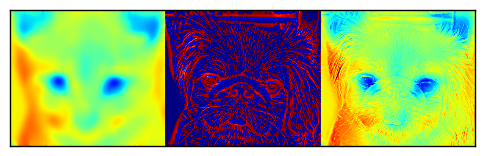

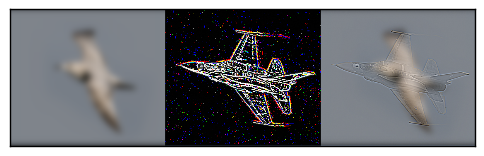

In [68]:
dog = cv2.imread('data/dog.bmp', flags=cv2.IMREAD_GRAYSCALE)
cat = cv2.imread('data/cat.bmp', flags=cv2.IMREAD_GRAYSCALE)

gato_perro = make_hybrid_image(cat,dog, 10, 4, True)

bird = cv2.imread('data/bird.bmp', flags=cv2.IMREAD_COLOR)
plane = cv2.imread('data/plane.bmp', flags=cv2.IMREAD_COLOR)

pajaro_avion = make_hybrid_image(bird,plane, 8, 1.5, True)

### C) Pirámide Gaussiana

#### Construir una pirámide Gaussiana de al menos 5 niveles con las imágenes híbridas calculadas en el apartado anterior. Mostrar los distintos niveles de la pirámide en un único canvas e interpretar el resultado.

Para resolver este ejercicio, he desarrollado la ***generate_new_pyramidal_canvas***. Esta función recibe como parámetros la imagen original, las veces que se desea mostrar la imagen en el canvas, y el factor de escalado de la imagen, que por defecto, se reducirá a la mitad la imagen.

Esta función, además, tiene otra función que limita el número de veces que podemos mostrar la imagen en el canvas, antes de que se haga demasiado pequeña (mínimo tamaño de la imagen, 10px de altura o 10px de anchura). Esta función es ***max_images_on_pyramidal_canvas*** y recibe como parámetros la imagen original, el número de píxeles en vertical que tiene el canvas y el factor de escalado de la imagen. La función calcula la altura que tendría la imagen con cada escalado y el ancho, y va acumulando el número de veces que se puede reducir la imagen sin que se haga demasiado pequeña. Una vez terminada, devuelve el máximo de imágenes que se pueden visualizar en el canvas.

Volviendo a la función ***generate_new_pyramidal_canvas***, la función genera un canvas vacío de color blanco con el siguiente tamaño:
- *Ancho del canvas*: el ancho del canvas es igual a la anchura de la imagen original, más la anchura de la imagen original dividida por el factor de escalado. Esto es así, porque las siguientes imágenes que se mostrarían en el canvas, podemos meterla en el espacio que quedaría en el canvas al ser de mucho menor tamaño.
- *Altura de la imagen*: es la altura de la imagen original.

Tras esto, se inserta la imagen original a la izquierda del canvas, y se pasa a un bucle que va insertando a la izquierda de esta imagen y de mayor a menor tamaño de forma piramidal, el resto de imágenes que queremos visualizar.

Cuando termina, devuelve el canvas generado.

In [ ]:
def subsample_image(img_src, subsample_factor = 2):
    alt, anch = img_src.shape[:2]
    # Obtenemos una máscara de suavizado
    smoothing_mask = get_mask_vector(1)
    # Suavizamos la máscara
    smoothed_img = my_im_gauss_convolution(im=img_src,mask_convolution=smoothing_mask)
    # Eliminamos las filas que queramos

    if len(img_src.shape) != 3:
        aux = smoothed_img[range(0, alt, subsample_factor)]
    else:
        # b_channel, g_channel, r_channel = cv2.split(aux)
        aux = smoothed_img[range(0, alt, subsample_factor),:]

    # Y devolvemos de la matriz anterior, todas las filas
    # y las columnas que queramos
    return aux[:, range(0,anch, subsample_factor)]


def max_images_on_pyramidal_canvas(img_src, canvas_rows, subsample_factor):

    floor = math.floor
    # Obtenemos el número de píxeles disponibles en filas para
    # poder crear la imagen
    rows_available = canvas_rows
    # Obtenemos la altura de la imagen para operar con ella
    # y obtener el máximo de imágenes que pueden entrar en el canvas
    height = canvas_rows
    length = img_src.shape[1]
    # Anotamos la altura a la que se encuentra el último
    # píxel de la imagen añadido
    n_imgs = 0
    # Al final de la imagen, se deja un margen prudencial
    # de 10 píxeles
    while rows_available >= height and \
            (height > 10 or length > 10):

        height = floor(height/subsample_factor)
        length = floor(length/subsample_factor)
        rows_available -= height

        n_imgs += 1

    return n_imgs


def generate_new_pyramidal_canvas(img_src, times_to_show, subsample_factor = 2):

    alt, anch = img_src.shape[:2]
    # Generamos un canvas vacío dependiendo de si la imagen es
    # en color o en escala de grises
    if len(img_src.shape) != 3:
        canvas = np.zeros((alt, anch + math.ceil(anch / subsample_factor)), 
                          dtype=np.uint8) + 255
    else:
        canvas = np.zeros((alt, anch + math.ceil(anch / subsample_factor),3), 
                          dtype=np.uint8) + 255
    
    # insertamos la imagen original a la izquierda del canvas
    insert_img_into_other(img_src=img_src, img_dest=canvas,
                          pixel_left_top_row=0, pixel_left_top_col=0,
                          substitute=True)
    # fila en la que se insertará la siguiente imagen
    # a la que se le aplicará el subsampling
    row = 0
    # imagen copia de la original con la que se trabajará
    im = np.copy(img_src)
    # máximo número de imágenes que se pueden incrustar en pirámide
    max = max_images_on_pyramidal_canvas(img_src, canvas.shape[1], subsample_factor)
    if times_to_show > max:
        times_to_show = max

    for i in range(0, times_to_show-1):
        # Realizamos el subsample
        im = subsample_image(img_src=im,
                             subsample_factor=subsample_factor)
        # insertamos la imagen en el canvas
        insert_img_into_other(img_src=im, img_dest=canvas,
                              pixel_left_top_row=row, pixel_left_top_col=anch,
                              substitute=True)
        # y anotamos en qué fila insertar la siguiente imagen
        row += im.shape[0]

    return canvas


A continuación, podemos ver un ejemplo de uso, visualizando la imágen híbrida generada con el pájaro y el avión.

In [ ]:
canvas = generate_new_pyramidal_canvas(pajaro_avion, times_to_show = 8)
show_img_on_jupyter(canvas)
canvas2 = generate_new_pyramidal_canvas(gato_perro, times_to_show = 4)
show_img_on_jupyter(canvas2)

En ella podemos ver cómo en la primera imagen se puede distinguir el avión en la imagen, y conforme se va reduciendo la imágen, empieza a aparecer el pájaro.